# Analysis on the scraped energy tweets

## Author: James Jordan

## Date: April 4, 2021

In [238]:
import os
import pickle
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import SVC
from sklearn.preprocessing import MultiLabelBinarizer

from wordcloud import WordCloud

%matplotlib inline

In [163]:
path = os.getcwd()
path_coal = os.path.join(path, 'data', 'coal_clean.pkl')
path_solar = os.path.join(path, 'data', 'solar_clean.pkl')
path_wind = os.path.join(path, 'data', 'wind_clean.pkl')
path_gas = os.path.join(path, 'data', 'gas_clean.pkl')
path_petro = os.path.join(path, 'data', 'petro_clean.pkl')
path_master = os.path.join(path, 'data', 'master.pkl')
path_to_ml_model = os.path.join(path, 'models', 'sentiment_classifier.pkl')
path_to_vectorizer = os.path.join(path, 'models', 'vectorizer.pkl')

In [164]:
df = pd.read_pickle(path_master)
df_coal = pd.read_pickle(path_coal)
df_solar = pd.read_pickle(path_solar)
df_wind = pd.read_pickle(path_wind)
df_gas = pd.read_pickle(path_gas)
df_petro = pd.read_pickle(path_petro)

In [165]:
ENERGY = ['coal', 'solar', 'wind', 'gas', 'petro']
TWITTER_USER_REGEX = r'@([a-zA-Z0-9_]+)'

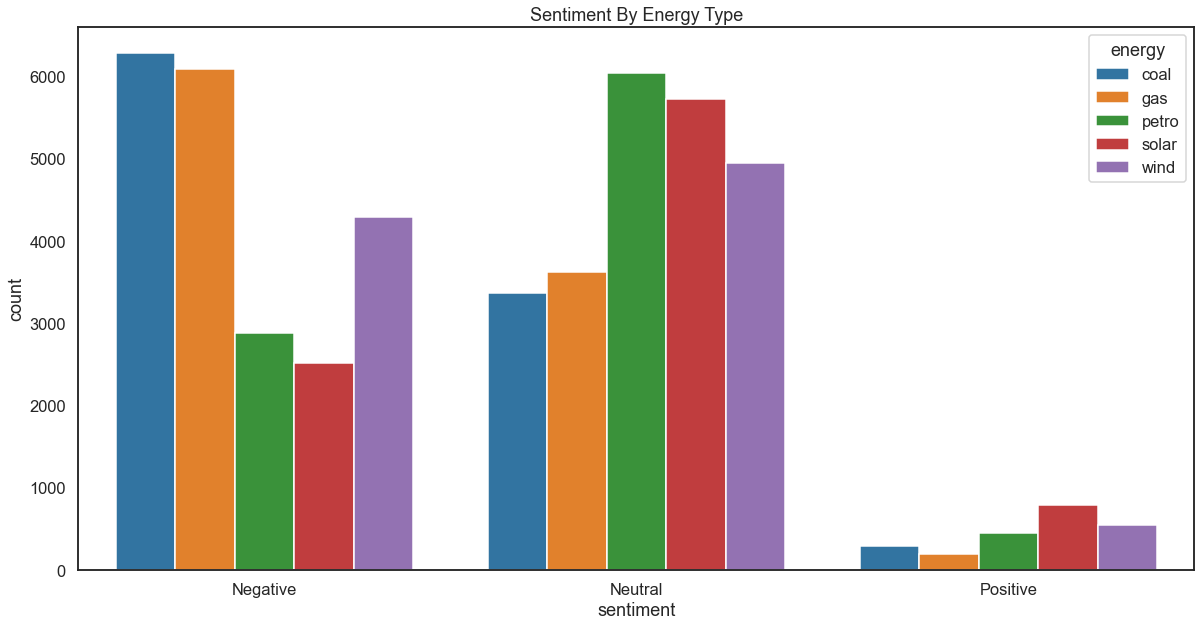

In [270]:
# Plot Sentiment vs. Energy type
df_group_energy = df_master.groupby('energy')['sentiment'].value_counts()
df_group_energy = pd.DataFrame(df_group_energy).rename(columns={'sentiment': 'count'}).reset_index()

sns.set_style('white')
sns.set_context('talk')
plt.figure(figsize=(20, 10))
sns.barplot(x=df_group_energy['sentiment'], y=df_group_energy['count'], hue=df_group_energy['energy'])
plt.title('Sentiment By Energy Type')
plt.xticks(ticks=[0, 1, 2], labels=['Negative', 'Neutral', 'Positive'])

path_fig = os.path.join(path, 'images', 'sentiment_by_energy.png')
fig = plt.gcf()
fig.savefig(path_fig, bbox_inches='tight', facecolor="w")

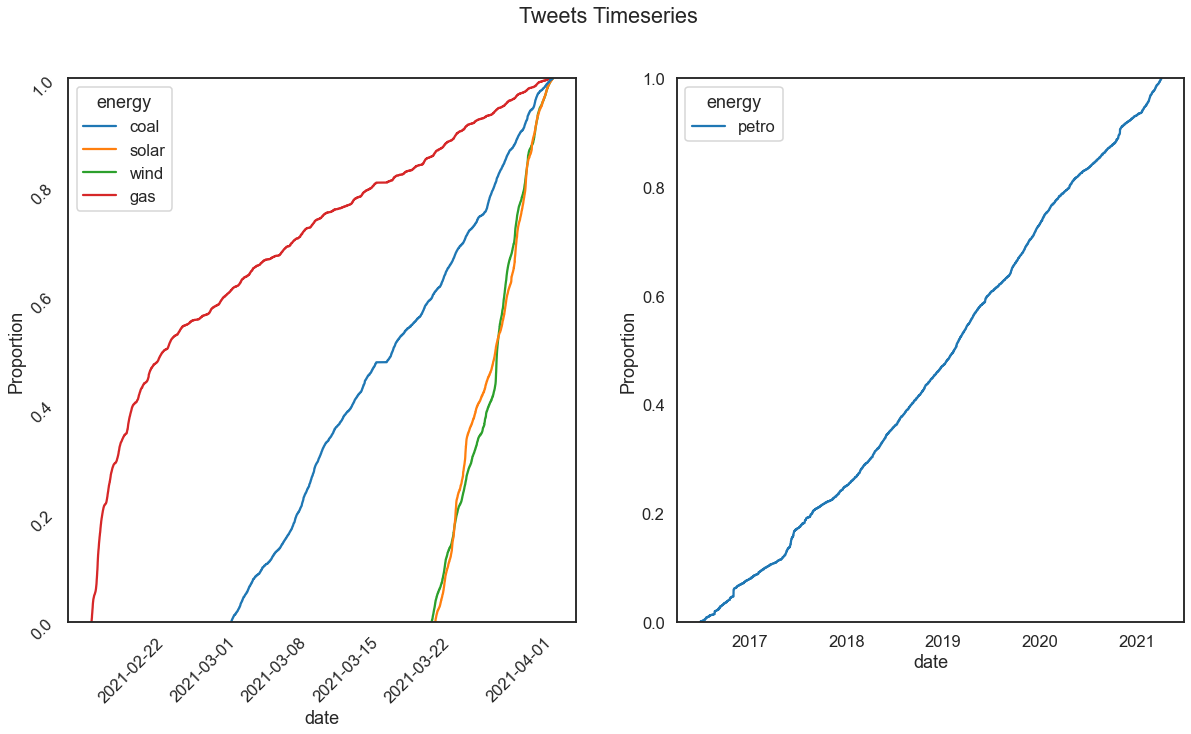

In [279]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
sns.ecdfplot(data=df[df['energy'] != 'petro'], x='date', hue='energy', ax=ax[0])
sns.ecdfplot(data=df[df['energy'] == 'petro'], x='date', hue='energy', ax=ax[1])

fig.suptitle('Tweets Timeseries')
ax[0].tick_params(labelrotation=45)

path_fig = os.path.join(path, 'images', 'tweet_timeseries.png')
plt.savefig(path_fig, bbox_inches='tight', facecolor="w")

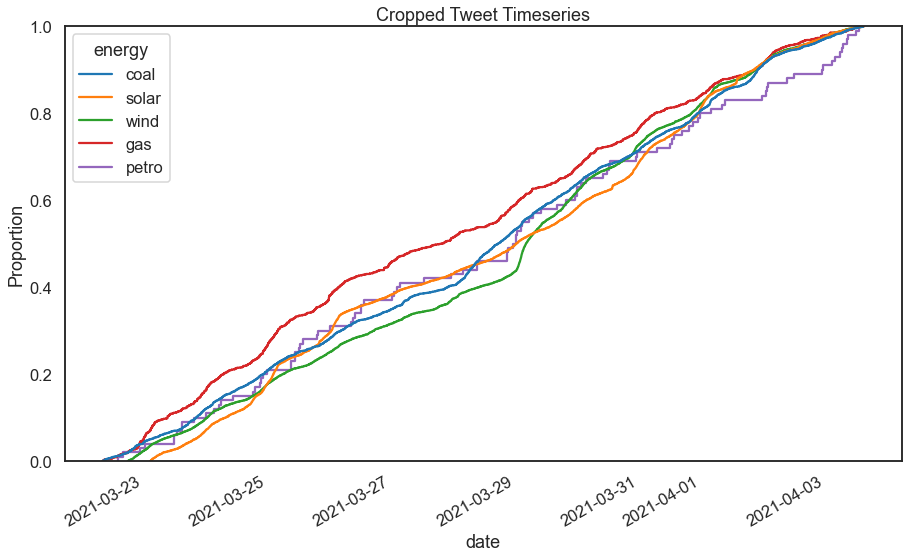

In [326]:
plt.figure(figsize=(15, 8))
sns.ecdfplot(data=df[df['date'] > '2021-03-23'], x='date', hue='energy')
plt.title('Cropped Tweet Timeseries')
plt.xticks(rotation=30)

path_fig = os.path.join(path, 'images', 'tweet_timeseries_crop.png')
fig = plt.gcf()
plt.savefig(path_fig, bbox_inches='tight', facecolor="w")

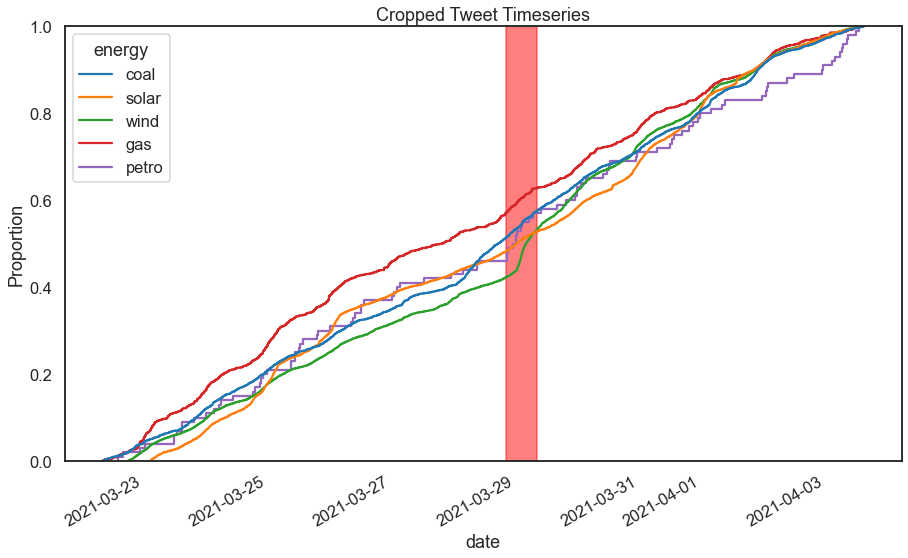

In [329]:
plt.figure(figsize=(15, 8))
sns.ecdfplot(data=df[df['date'] > '2021-03-23'], x='date', hue='energy')
plt.title('Cropped Tweet Timeseries')
plt.axvspan(datetime(2021, 3, 29, 12), datetime(2021, 3, 30), color='red', alpha=0.5)
plt.xticks(rotation=30)

path_fig = os.path.join(path, 'images', 'tweet_timeseries_crop_highlight.png')
fig = plt.gcf()
plt.savefig(path_fig, bbox_inches='tight', facecolor="w")

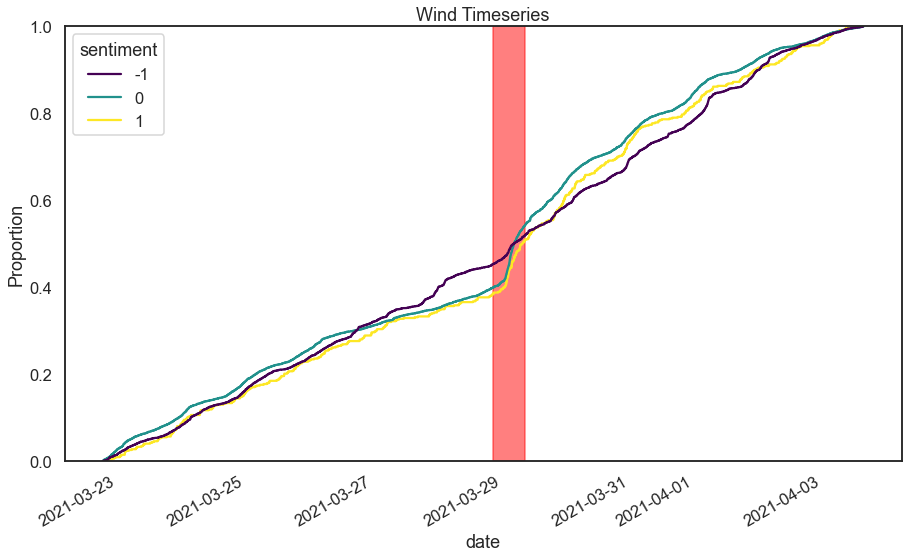

In [327]:
plt.figure(figsize=(15, 8))
sns.ecdfplot(data=df[(df['date'] > '2021-03-23') & (df['energy'] == 'wind')], x='date', hue='sentiment', palette='viridis')
plt.title('Wind Timeseries')
plt.axvspan(datetime(2021, 3, 29, 12), datetime(2021, 3, 30), color='red', alpha=0.5)
plt.xticks(rotation=30)

path_fig = os.path.join(path, 'images', 'wind_only.png')
fig = plt.gcf()
plt.savefig(path_fig, bbox_inches='tight', facecolor="w")

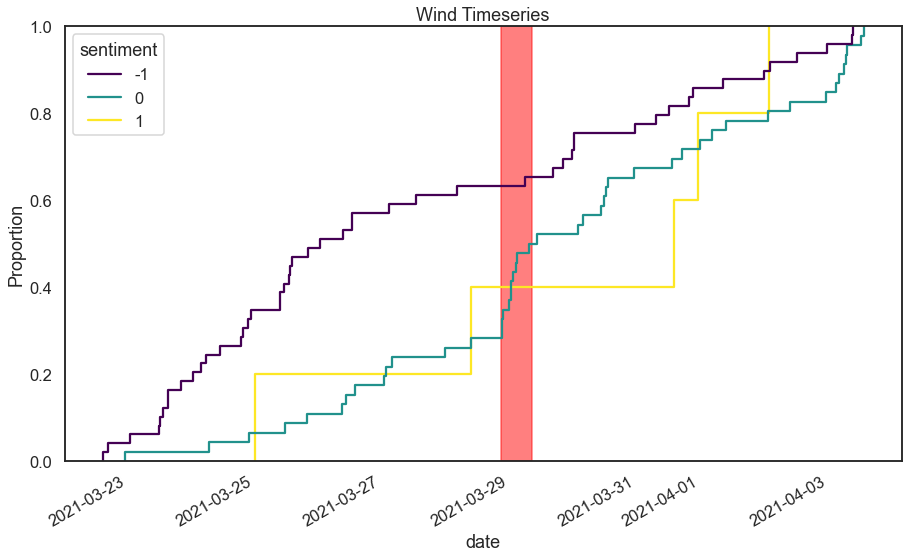

In [328]:
plt.figure(figsize=(15, 8))
sns.ecdfplot(data=df[(df['date'] > '2021-03-23') & (df['energy'] == 'petro')], x='date', hue='sentiment', palette='viridis')
plt.title('Wind Timeseries')
plt.axvspan(datetime(2021, 3, 29, 12), datetime(2021, 3, 30), color='red', alpha=0.5)
plt.xticks(rotation=30)

path_fig = os.path.join(path, 'images', 'petro_only.png')
fig = plt.gcf()
plt.savefig(path_fig, bbox_inches='tight', facecolor="w")

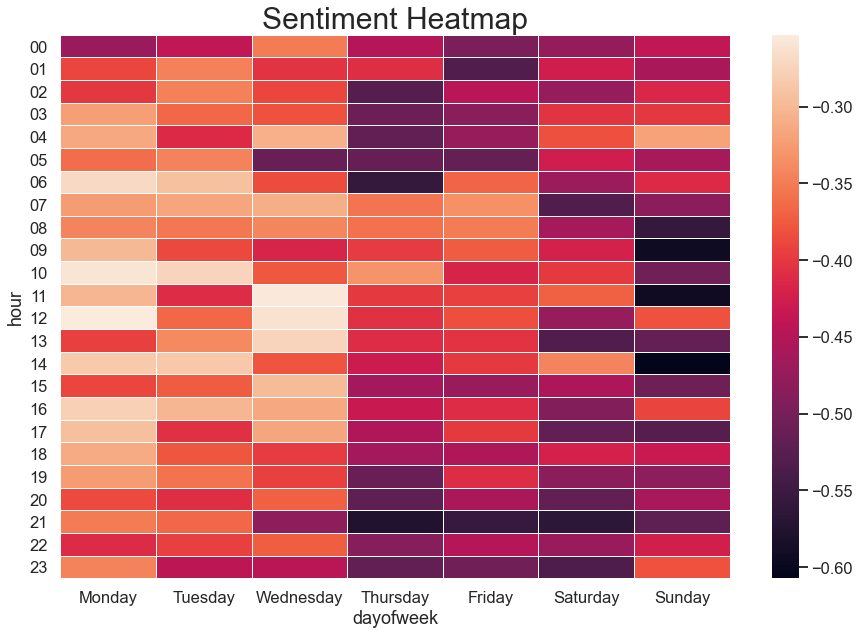

In [275]:
df['dayofweek'] = df['date'].dt.day_name()
df_hm = df.groupby(['dayofweek', 'hour'])['sentiment'].mean().reset_index().pivot(index='hour', columns='dayofweek', values='sentiment')
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df_hm = df_hm[days_order]

sns.set_context('talk')
plt.figure(figsize=(15, 10))
sns.heatmap(df_hm, linewidths=.5)
plt.title('Sentiment Heatmap', fontsize=30)
plt.yticks(rotation=0)

path_fig = os.path.join(path, 'images', 'sentiment_heatmap.png')
fig = plt.gcf()
plt.savefig(path_fig, bbox_inches='tight', facecolor="w");

## Mentions and Hashtag Wordclouds

In [237]:
def create_sums_variable(df_sums, mentions=False, hashtags=False):
    '''
    Returns either mentions or hashtags into a list of occurrences within tweets dataframe
    '''
    if mentions:
        s = df_sums['mentions']
        mlb = MultiLabelBinarizer()
        df_mentions = pd.DataFrame(mlb.fit_transform(s), columns=mlb.classes_)
        sum_variable = df_mentions.sum(axis=0, skipna=True).sort_values(ascending=False)
        return sum_variable
    elif hashtags:
        s = df_sums['hashtags']
        mlb = MultiLabelBinarizer()
        df_hashtags = pd.DataFrame(mlb.fit_transform(s), columns=mlb.classes_)
        sum_variable = df_hashtags.sum(axis=0, skipna=True).sort_values(ascending=False)
        return sum_variable
    else:
        print('Do you want hashtags or mentions??')

In [344]:
sum_hashtags = create_sums_variable(df_petro, hashtags=True)
sum_mentions = create_sums_variable(df_petro, mentions=True)
sum_mentions = sum_mentions.drop('', axis=0)

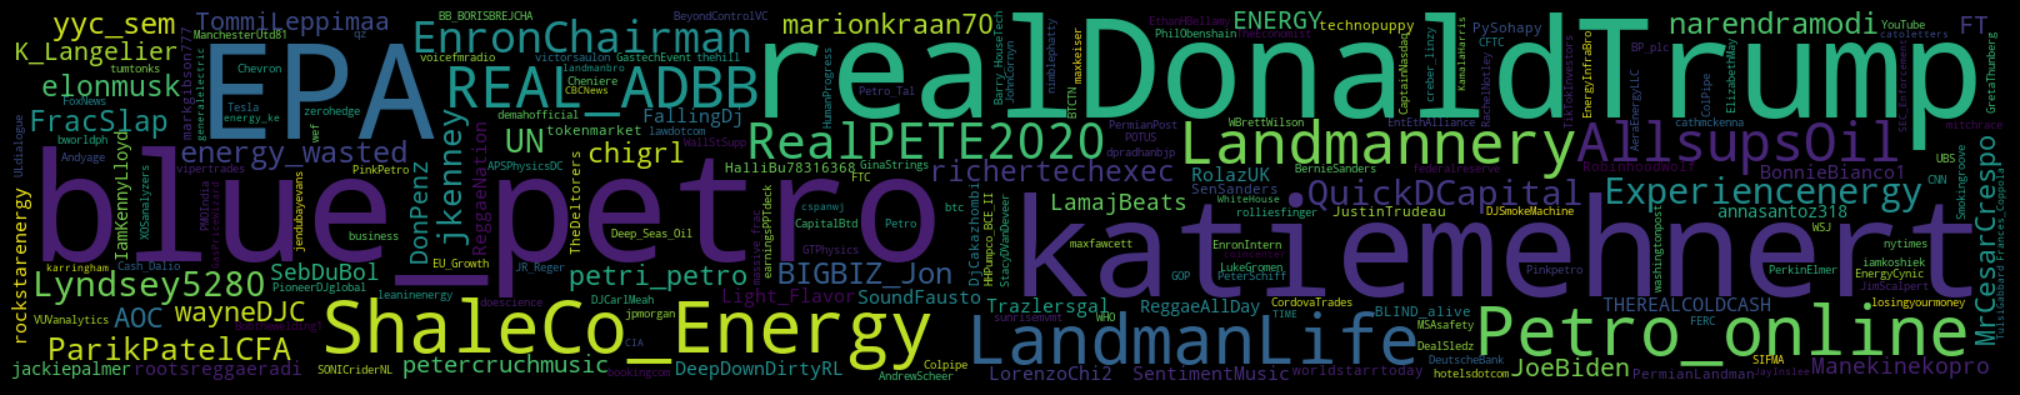

In [345]:
mentions_dict = sum_mentions.to_dict()
wordcloud = WordCloud(width=1600, height=300).generate_from_frequencies(mentions_dict)

plt.figure(figsize = (20,10), dpi=100, facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)

path_fig = os.path.join(path, 'images', 'petro_mentions.png')
fig = plt.gcf()
plt.savefig(path_fig, bbox_inches='tight');

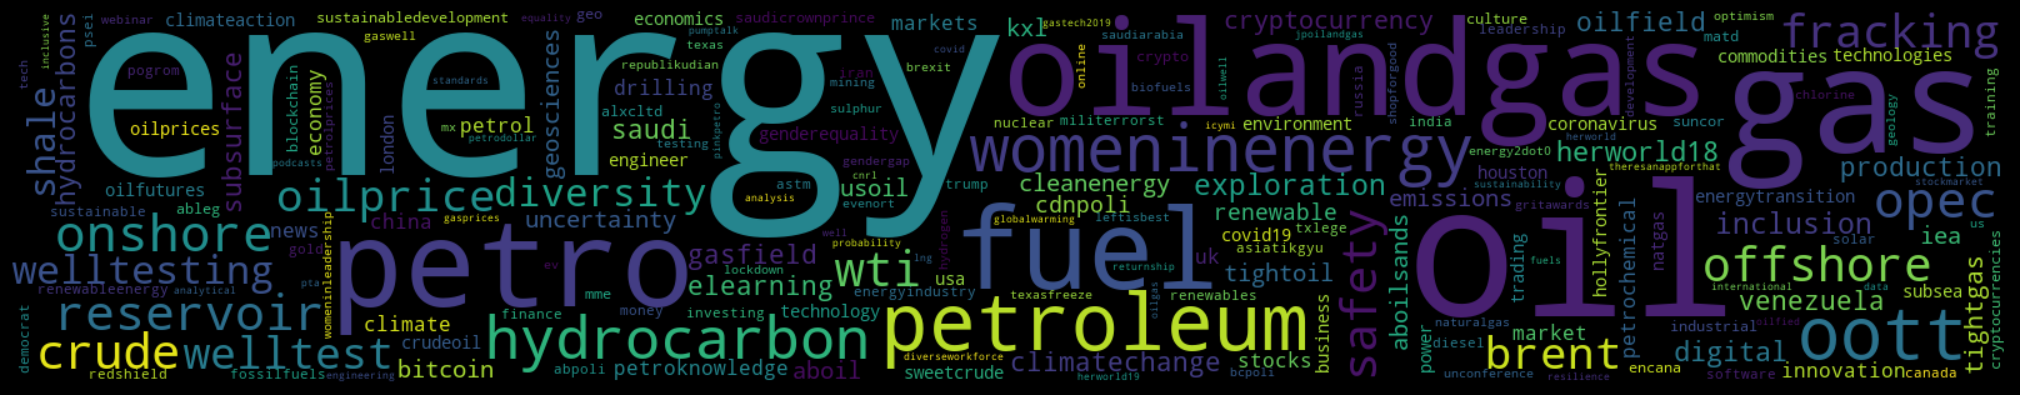

In [346]:
hashtags_dict = sum_hashtags.to_dict()
wordcloud = WordCloud(width=1600, height=300).generate_from_frequencies(hashtags_dict)

plt.figure(figsize = (20,10), dpi=100, facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)

path_fig = os.path.join(path, 'images', 'petro_hashtags.png')
fig = plt.gcf()
plt.savefig(path_fig, bbox_inches='tight');

In [280]:
len(df)

48074

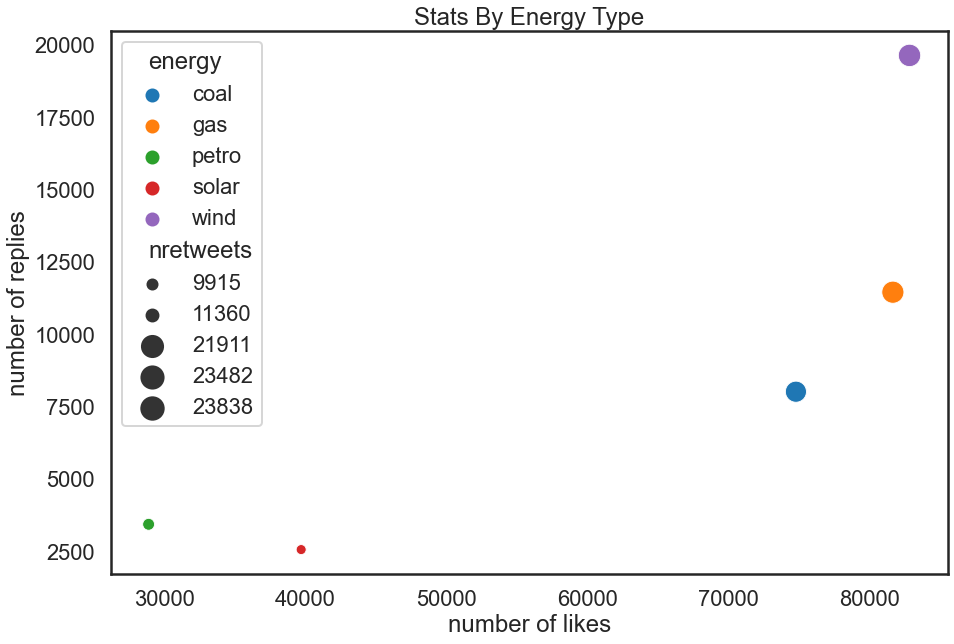

In [309]:
totals = df.groupby(['energy'])[['nlikes', 'nretweets', 'nreplies']].sum().reset_index()

sns.set_context('poster')
plt.figure(figsize=(15, 10))
sns.scatterplot(data=totals, x='nlikes', y='nreplies', hue='energy', size='nretweets', sizes=(100, 500))

plt.title('Stats By Energy Type')
plt.xlabel('number of likes')
plt.ylabel('number of replies')

path_fig = os.path.join(path, 'images', 'stats_energy.png')
fig = plt.gcf()
plt.savefig(path_fig, bbox_inches='tight');
sns.set_context('talk')

In [310]:
df['date'].min()

Timestamp('2016-06-27 19:59:30')

In [312]:
df['count'] = 1

In [317]:
total_tweets = len(df)

In [324]:
users_group = df.groupby(['username'])['count'].sum().sort_values(ascending=False).to_frame()
users_group['percent_total'] = users_group['count'] / total_tweets
users_group = users_group.reset_index()
users_group.head(10)

username  count  percent_total
0  YootDigmeMusic   1256       0.026126
1  renvyleweather    956       0.019886
2     DEEPSTUPID2    581       0.012086
3       HALMACDAL    478       0.009943
4   ALLYEnergyInc    459       0.009548
5    Petro_online    434       0.009028
6    doodleoddity    428       0.008903
7  UK_SolarEnergy    288       0.005991
8     petro_verde    209       0.004347
9    realyashnegi    161       0.003349